In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_nonlinear_dataset():
  N = 1000 # number of points per class
  D = 2 # dimensionality
  K = 2 # number of classes
  X = np.zeros((D,N*K)) # data matrix (each column = single example)
  y = np.zeros(N*K, dtype='uint8') # class labels , column vector
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[j] = np.r_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
  # lets visualize the data:
  plt.scatter(X[1], X[0], c=y, s=40, cmap=plt.cm.Spectral)
  plt.show()
  return X,y

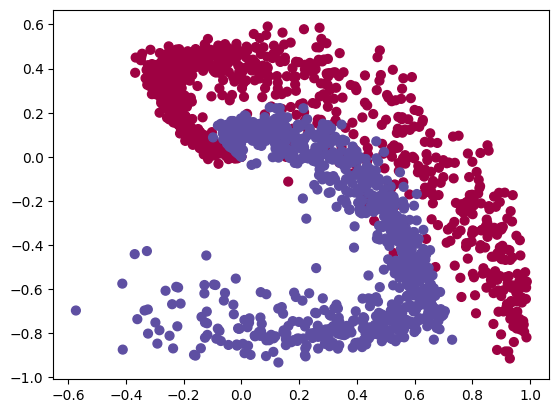

In [3]:
X , y = generate_nonlinear_dataset()

In [4]:
def initialise_parameters(layer_dims):
  np.random.seed(3)

  L = len(layer_dims)
  parameters = {}

  for l in range(1,L): # it is [1,L-1] as we dont count input layer in layer calculation , therfore there are L-1 layers
    W = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
    b = np.zeros((layer_dims[l],1))
    parameters["W"+str(l)] = W
    parameters["b"+str(l)] = b
  return parameters

# layer_dims = [2,4,8,1]
# parameters = initialise_parameters(layer_dims)

In [5]:
from scipy.special import expit
def forward_propogation(X,parameters):
  L = len(parameters) // 2
  activation_caches = [{}]
  linear_caches = [X]
  A = X

  for l in range(1,L):
    A_prev = A
    Z = np.add(np.matmul(parameters["W"+str(l)],A_prev),parameters["b"+str(l)])
    A = np.maximum(0,Z) # adding relu activation to hidden layers
    linear_caches.append(A)
    activation_caches.append(Z)
  
  # for last layer , i.e output layer
  Z = np.add(np.matmul(parameters["W"+str(L)],A),parameters["b"+str(L)])
  y_hat = expit(Z) # applying sigmoid activation to last layer
  linear_caches.append(y_hat)
  activation_caches.append(Z)

  return y_hat,activation_caches , linear_caches
# y_hat , activation_caches , linear_caches = forward_propogation(X,parameters)

In [35]:
def compute_cost(Y,Y_hat):
  m = Y.shape[0]
  # print(m)
  cost = -(np.dot(Y,np.log(Y_hat[0])) + np.dot(1-Y,np.log(1-Y_hat[0])))/m
  np.squeeze(cost)
  return cost
# cost = compute_cost(y,y_hat)
# print(cost)

In [7]:
def backward_propogation(Y,Y_hat,activation_caches,linear_caches,parameters):
  grads = {}
  # caches contain all the values of zl 
  m = Y.shape[0]
  Y = Y.reshape(Y_hat.shape) # Y is same shape as Y_hat now
  L = len(activation_caches)-1 # number of layers
  # print(L)
   
  # for last layer
  dAL = -(np.divide(Y,Y_hat) - np.divide(1-Y,1-Y_hat))
  dZL = np.multiply(dAL , (Y_hat - np.square(Y_hat))) # As sigmoid activation was used in last layer
  dA_prev_temp = np.matmul(parameters["W"+str(L)].transpose() , dZL)
  grads["dA"+str(L-1)] = dA_prev_temp
  grads["dW"+str(L)] = np.matmul(dZL , linear_caches[L-1].transpose())/m
  grads["db"+str(L)] = np.sum(dZL,axis=1,keepdims=True)/m
  # print(dZL.shape,grads["dW"+str(L)].shape ,parameters["W"+str(L)].shape,linear_caches[L-1].shape )

  for l in reversed(range(1,L)): # goes from L-1 to 1
    derivate_of_relu_activation_function = np.where(activation_caches[l]>0,1,0)
    dZ = np.multiply(dA_prev_temp,derivate_of_relu_activation_function)
    dA_prev_temp = np.matmul(parameters["W"+str(l)].transpose() , dZ)
    grads["dA"+str(l-1)] = dA_prev_temp
    grads["dW"+str(l)] = np.matmul(dZ , linear_caches[l-1].transpose())/m
    grads["db"+str(l)] = np.sum(dZ,axis=1,keepdims=True)/m

    # print(grads["dW"+str(l)].shape ,parameters["W"+str(l)].shape , linear_caches[l-1].shape )

  return grads

# grads = backward_propogation(y,y_hat,activation_caches , linear_caches,parameters) 


In [8]:
def update_parameters(parameters , grads , learning_rate):
  L = len(parameters)//2
  params = parameters.copy()

  for l in range(1,L+1):
    params["W"+str(l)] = parameters["W"+str(l)] - learning_rate*grads["dW"+str(l)]
    params["b"+str(l)] = parameters["b"+str(l)] - learning_rate*grads["db"+str(l)]
  
  return params
# print("Old Parameters have W1 as ",parameters["W1"])
# parameters = update_parameters(parameters,grads,100)
# print("New Parameters have W1 as ",parameters["W1"])

In [ ]:
def multilayer_neural_network(X,Y,layer_dims,number_iterations,learning_rate):
  parameters = initialise_parameters(layer_dims)

  costs = []

  for i in range(number_iterations):
    y_hat , activation_caches , linear_caches = forward_propogation(X,parameters)
    costi = compute_cost(Y,y_hat)
    costs.append(costi)
    

    grads = backward_propogation(Y,y_hat,activation_caches , linear_caches,parameters) 
    parameters = update_parameters(parameters,grads,learning_rate)
  print(f"Cost at the end is {costs[-1]}")
  return parameters,costs

params , costs = multilayer_neural_network(X,y,layer_dims = [2,1024,512,8,1],learning_rate=1 ,number_iterations=10000)

#plot costs
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
# plt.title("Learning rate =" + str(learning_rate))
plt.show()